<a href="https://colab.research.google.com/github/batiukmaks/Computer-Vision-Labs/blob/main/Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Dependencies

In [36]:
!pip install openimages

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.6/139.6 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 110.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.4/84.4 kB 7.9 MB/s eta 0:00:00


# Imports

In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
import os

import os
import shutil
import random
from glob import glob

from openimages.download import download_dataset

In [66]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.transforms.functional import to_pil_image
import torch
import random
from sklearn.metrics import average_precision_score
import numpy as np
import torch
from tqdm import tqdm
from torch import optim
from tqdm import tqdm
import os
import torch
from torch.utils.data import DataLoader
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import xml.etree.ElementTree as ET
import torchvision.transforms as T

import torch.nn as nn

from torch.optim.lr_scheduler import ReduceLROnPlateau

# Define Constants

In [39]:
BASE_DIR = "/content/drive/MyDrive/Term 8/CV/Lab4"

DATA_DIR = os.path.join(BASE_DIR, "data")
RAW_DATA_DIR = os.path.join(DATA_DIR, "raw")
PREPROCESSED_DATA_DIR = os.path.join(DATA_DIR, "preprocessed")

MODELS_DIR = os.path.join(BASE_DIR, "models")

In [45]:
CLASS_LABELS=['Dog', 'Car', "Hammer", "Scissors", "Chair"][:2]
NUM_CLASSES = len(CLASS_LABELS)

In [56]:
BATCH_SIZE = 16

In [61]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Preparation

In [41]:
shutil.rmtree(DATA_DIR)

In [46]:
download_dataset(
    dest_dir=RAW_DATA_DIR,
    class_labels=CLASS_LABELS,
    annotation_format='pascal',
    limit=500,
)

100%|██████████| 500/500 [00:05<00:00, 89.70it/s]


{'dog': {'images_dir': '/content/drive/MyDrive/Term 8/CV/Lab4/data/raw/dog/images',
  'annotations_dir': '/content/drive/MyDrive/Term 8/CV/Lab4/data/raw/dog/pascal'},
 'car': {'images_dir': '/content/drive/MyDrive/Term 8/CV/Lab4/data/raw/car/images',
  'annotations_dir': '/content/drive/MyDrive/Term 8/CV/Lab4/data/raw/car/pascal'},
 'hammer': {'images_dir': '/content/drive/MyDrive/Term 8/CV/Lab4/data/raw/hammer/images',
  'annotations_dir': '/content/drive/MyDrive/Term 8/CV/Lab4/data/raw/hammer/pascal'},
 'scissors': {'images_dir': '/content/drive/MyDrive/Term 8/CV/Lab4/data/raw/scissors/images',
  'annotations_dir': '/content/drive/MyDrive/Term 8/CV/Lab4/data/raw/scissors/pascal'},
 'chair': {'images_dir': '/content/drive/MyDrive/Term 8/CV/Lab4/data/raw/chair/images',
  'annotations_dir': '/content/drive/MyDrive/Term 8/CV/Lab4/data/raw/chair/pascal'}}

In [48]:
def split_data(
    raw_data_dir: str,
    output_dir: str,
    class_labels: list,
    split_ratio: tuple = (0.7, 0.15, 0.15),
    seed: int = 42
):
    """
    Розбиває дані Pascal VOC з Open Images на train/val/test.

    Args:
        raw_data_dir (str): Шлях до сировинних даних (raw/class_name/{images,pascal}).
        output_dir (str): Куди зберігати препроцесовані дані.
        class_labels (list): Список класів, які були завантажені.
        split_ratio (tuple): Розподіл (train, val, test), сума має бути 1.0.
        seed (int): Seed для відтворюваності.
    """
    assert abs(sum(split_ratio) - 1.0) < 1e-6, "Сума split_ratio повинна дорівнювати 1.0"

    splits = ["train", "val", "test"]

    # Створення директорій
    for split in splits:
        os.makedirs(os.path.join(output_dir, split, "images"), exist_ok=True)
        os.makedirs(os.path.join(output_dir, split, "annotations"), exist_ok=True)

    # Збираємо (image, annotation) пари
    image_annotation_pairs = []
    for cls in class_labels:
        cls = cls.lower()
        images_dir = os.path.join(raw_data_dir, cls, "images")
        annotations_dir = os.path.join(raw_data_dir, cls, "pascal")
        image_paths = sorted(glob(os.path.join(images_dir, "*.jpg")))

        for img_path in image_paths:
            image_id = os.path.splitext(os.path.basename(img_path))[0]
            ann_path = os.path.join(annotations_dir, f"{image_id}.xml")
            if os.path.exists(ann_path):
                image_annotation_pairs.append((img_path, ann_path))

    # Shuffle та split
    random.seed(seed)
    random.shuffle(image_annotation_pairs)

    n = len(image_annotation_pairs)
    train_end = int(split_ratio[0] * n)
    val_end = train_end + int(split_ratio[1] * n)

    splits_data = {
        "train": image_annotation_pairs[:train_end],
        "val": image_annotation_pairs[train_end:val_end],
        "test": image_annotation_pairs[val_end:]
    }

    # Копіюємо файли
    for split, pairs in splits_data.items():
        for img_path, ann_path in pairs:
            shutil.copy(img_path, os.path.join(output_dir, split, "images", os.path.basename(img_path)))
            shutil.copy(ann_path, os.path.join(output_dir, split, "annotations", os.path.basename(ann_path)))

    print(f"✅ Готово! Розбивка завершена: {output_dir}")


In [49]:
split_data(
    raw_data_dir=RAW_DATA_DIR,
    output_dir=PREPROCESSED_DATA_DIR,
    class_labels=CLASS_LABELS
)

✅ Готово! Розбивка завершена: /content/drive/MyDrive/Term 8/CV/Lab4/data/preprocessed


# Model Initialization

In [155]:
# class OverFeat(nn.Module):
#     def __init__(self, num_classes):
#         super(OverFeat, self).__init__()

#         # Feature extractor (AlexNet style)
#         self.features = nn.Sequential(
#             nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),  # 224 -> 54
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=3, stride=2),                  # 54 -> 26

#             nn.Conv2d(96, 256, kernel_size=5, padding=2),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=3, stride=2),                  # 26 -> 12

#             nn.Conv2d(256, 512, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),

#             nn.Conv2d(512, 1024, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),

#             nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=3, stride=2)                   # 12 -> 5
#         )

#         self.flatten = nn.Flatten()

#         # Fully connected part (shared)
#         self.fc = nn.Sequential(
#             nn.Linear(1024 * 5 * 5, 3072),
#             nn.ReLU(inplace=True),
#             nn.Linear(3072, 4096),
#             nn.ReLU(inplace=True)
#         )

#         # Classification head
#         self.classifier = nn.Linear(4096, num_classes)

#         # Bounding box regression head: (x_center, y_center, width, height)
#         self.bbox_regressor = nn.Linear(4096, 4)

#     def forward(self, x):
#         x = self.features(x)
#         x = self.flatten(x)
#         x = self.fc(x)

#         class_logits = self.classifier(x)
#         bbox_coords = self.bbox_regressor(x)

#         return class_logits, bbox_coords

In [176]:
import torch
import torch.nn as nn
import torchvision.models as models

class OverFeat(nn.Module):
    def __init__(self, num_classes, freeze_pretrained=True):
        super(OverFeat, self).__init__()

        # 🔁 Load pretrained AlexNet and extract first few conv layers
        pretrained_alexnet = models.alexnet(pretrained=True)
        pretrained_layers = list(pretrained_alexnet.features.children())[:6]  # conv1 → maxpool2

        # 💡 Optionally freeze pretrained layers
        if freeze_pretrained:
            for layer in pretrained_layers:
                for param in layer.parameters():
                    param.requires_grad = False

        # ⛏️ Custom continuation of feature extractor
        self.features = nn.Sequential(
            *pretrained_layers,  # Outputs feature map with shape [256, 13, 13] for input 224x224
            nn.Conv2d(192, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=3, stride=2)  # down to [1024, 5, 5]
        )

        self.flatten = nn.Flatten()

        # 💾 Fully connected part (shared)
        self.fc = nn.Sequential(
            nn.Linear(1024 * 6 * 6, 3072),
            nn.ReLU(inplace=True),
            nn.Linear(3072, 4096),
            nn.ReLU(inplace=True)
        )

        # 🧠 Heads
        self.classifier = nn.Linear(4096, num_classes)
        self.bbox_regressor = nn.Linear(4096, 4)

    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        x = self.fc(x)

        class_logits = self.classifier(x)
        bbox_coords = self.bbox_regressor(x)

        return class_logits, bbox_coords


In [177]:
class OverFeatLoss(nn.Module):
    def __init__(self, lambda_bbox=1.0):
        super().__init__()
        self.classification_loss = nn.CrossEntropyLoss()
        self.regression_loss = nn.SmoothL1Loss()
        self.lambda_bbox = lambda_bbox  # ваговий коефіцієнт

    def forward(self, pred_class_logits, pred_bboxes, true_labels, true_bboxes):
        # Classification loss
        cls_loss = self.classification_loss(pred_class_logits, true_labels)

        # Bounding box regression loss
        reg_loss = self.regression_loss(pred_bboxes, true_bboxes)

        # Combine
        total_loss = cls_loss + self.lambda_bbox * reg_loss
        return total_loss, cls_loss, reg_loss

In [178]:
class OverFeatDataset(Dataset):
    def __init__(self, images_dir, annotations_dir, class_to_idx, transform=None, image_size=(224, 224)):
        self.images_dir = images_dir
        self.annotations_dir = annotations_dir
        self.class_to_idx = class_to_idx  # {'dog': 0, 'car': 1, ...}
        self.image_size = image_size
        self.transform = transform or T.Compose([
            T.Resize(image_size),
            T.ToTensor()
        ])

        self.image_paths = sorted([
            os.path.join(images_dir, f)
            for f in os.listdir(images_dir)
            if f.endswith(('.jpg', '.jpeg', '.png'))
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert("RGB")
        width, height = img.size

        # Load annotation
        image_id = os.path.splitext(os.path.basename(img_path))[0]
        ann_path = os.path.join(self.annotations_dir, f"{image_id}.xml")
        tree = ET.parse(ann_path)
        root = tree.getroot()

        # Парсимо перший об'єкт (для простоти, 1 obj per image)
        obj = root.find("object")
        class_name = obj.find("name").text.lower()
        label = self.class_to_idx[class_name]

        bbox = obj.find("bndbox")
        xmin = float(bbox.find("xmin").text)
        ymin = float(bbox.find("ymin").text)
        xmax = float(bbox.find("xmax").text)
        ymax = float(bbox.find("ymax").text)

        # Конвертуємо в (x_center, y_center, w, h) і нормалізуємо
        x_center = ((xmin + xmax) / 2) / width
        y_center = ((ymin + ymax) / 2) / height
        w = (xmax - xmin) / width
        h = (ymax - ymin) / height

        bbox_tensor = torch.tensor([x_center, y_center, w, h], dtype=torch.float32)

        # Трансформуємо зображення
        img = self.transform(img)

        return img, label, bbox_tensor

In [179]:
def load_best_model(model, models_dir="models", device="cpu"):
    """
    Завантажує найновішу модель best_model_*.pt з вказаної директорії.

    Returns:
        model: з підвантаженими вагами
    """
    import glob

    pattern = os.path.join(models_dir, "best_model_*.pt")
    model_paths = glob.glob(pattern)

    if not model_paths:
        raise FileNotFoundError(f"❌ У папці {models_dir} немає моделей 'best_model_*.pt'")

    latest_model_path = max(model_paths, key=os.path.getmtime)
    model.load_state_dict(torch.load(latest_model_path, map_location=device))
    model.to(device)
    model.eval()
    print(f"✅ Завантажено найновішу модель: {latest_model_path}")
    return model


In [180]:
class_to_idx = {'dog': 0, 'car': 1, 'hammer': 2, 'scissors': 3, 'chair': 4}

train_dataset = OverFeatDataset(
    images_dir=os.path.join(DATA_DIR, "preprocessed/train/images"),
    annotations_dir=os.path.join(DATA_DIR, "preprocessed/train/annotations"),
    class_to_idx=class_to_idx
)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = OverFeatDataset(
    images_dir=os.path.join(DATA_DIR, "preprocessed/val/images"),
    annotations_dir=os.path.join(DATA_DIR, "preprocessed/val/annotations"),
    class_to_idx=class_to_idx
)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [181]:
model = OverFeat(num_classes=NUM_CLASSES)

# Training

In [182]:
def validate(model, val_loader, loss_fn, device, epoch=None, num_epochs=None):
    model.eval()
    val_loss, val_cls, val_reg = 0.0, 0.0, 0.0

    desc = f"Validation"
    if epoch is not None and num_epochs is not None:
        desc = f"Epoch {epoch+1}/{num_epochs} [Val]"

    val_loop = tqdm(val_loader, desc=desc, leave=False)

    with torch.no_grad():
        for images, labels, bboxes in val_loop:
            images = images.to(device)
            labels = labels.to(device)
            bboxes = bboxes.to(device)

            class_logits, pred_bboxes = model(images)
            loss, cls_loss, reg_loss = loss_fn(class_logits, pred_bboxes, labels, bboxes)

            val_loss += loss.item()
            val_cls += cls_loss.item()
            val_reg += reg_loss.item()

            val_loop.set_postfix(loss=loss.item(), cls=cls_loss.item(), reg=reg_loss.item())

    num_batches = len(val_loader)
    avg_val_loss = val_loss / num_batches
    avg_cls_loss = val_cls / num_batches
    avg_reg_loss = val_reg / num_batches

    return avg_val_loss, avg_cls_loss, avg_reg_loss

In [183]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, device, epoch=None, num_epochs=None):
    model.train()
    train_loss, train_cls, train_reg = 0.0, 0.0, 0.0

    desc = f"Training"
    if epoch is not None and num_epochs is not None:
        desc = f"Epoch {epoch+1}/{num_epochs} [Train]"

    loop = tqdm(train_loader, desc=desc, leave=False)

    for images, labels, bboxes in loop:
        images = images.to(device)
        labels = labels.to(device)
        bboxes = bboxes.to(device)

        optimizer.zero_grad()
        class_logits, pred_bboxes = model(images)
        loss, cls_loss, reg_loss = loss_fn(class_logits, pred_bboxes, labels, bboxes)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_cls += cls_loss.item()
        train_reg += reg_loss.item()

        loop.set_postfix(loss=loss.item(), cls=cls_loss.item(), reg=reg_loss.item())

    num_batches = len(train_loader)
    avg_train_loss = train_loss / num_batches
    avg_cls_loss = train_cls / num_batches
    avg_reg_loss = train_reg / num_batches

    return avg_train_loss, avg_cls_loss, avg_reg_loss

In [184]:
from datetime import datetime

def train_model(model, loss_fn, optimizer, train_loader, val_loader, device,
                num_epochs=10, models_dir="models", is_load_best_model=False, patience=5):
    model.to(device)
    best_val_loss = float("inf")
    epochs_no_improve = 0
    os.makedirs(models_dir, exist_ok=True)

    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True, min_lr=1e-6)

    # Load latest best model if requested
    if load_best_model:
        try:
            model = load_best_model(model, models_dir, device)
        except FileNotFoundError:
            print("⚠️ Не знайдено збереженої моделі — починаємо з нуля.")

    for epoch in range(num_epochs):
        # === Train ===
        avg_train_loss, avg_cls_loss, avg_reg_loss = train_one_epoch(
            model, train_loader, loss_fn, optimizer, device, epoch, num_epochs
        )

        # === Validate ===
        avg_val_loss, avg_cls_val_loss, avg_reg_val_loss = validate(
            model, val_loader, loss_fn, device, epoch, num_epochs
        )

        print(f"\n📊 Epoch [{epoch+1}/{num_epochs}]")
        print(f"  🔹 Train Loss: {avg_train_loss:.4f} | Cls: {avg_cls_loss:.4f} | Reg: {avg_reg_loss:.4f}")
        print(f"  🔸 Val   Loss: {avg_val_loss:.4f} | Cls: {avg_cls_val_loss:.4f} | Reg: {avg_reg_val_loss:.4f}")

        # === Scheduler ===
        scheduler.step(avg_val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        print(f"🔁 Поточний learning rate: {current_lr:.6f}")

        # === Early stopping + saving
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
            os.makedirs(models_dir, exist_ok=True)
            model_path = os.path.join(models_dir, f"best_model_{timestamp}.pt")
            torch.save(model.state_dict(), model_path)
            epochs_no_improve = 0
            print(f"✅ Найкращу модель збережено до {model_path}")
        else:
            epochs_no_improve += 1
            print(f"⚠️  Без покращення вже {epochs_no_improve} епох(и)")

        if epochs_no_improve >= patience:
            print(f"\n⏹️  Early stopping: валідаційна помилка не покращується протягом {patience} епох.")
            break

In [192]:
loss_fn = OverFeatLoss(lambda_bbox=15.0)
optimizer = optim.Adam(model.parameters(), lr=1e-2)

train_model(
    model=model,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    num_epochs=50,
    models_dir=MODELS_DIR,
    is_load_best_model=True,
    patience=3
)

✅ Завантажено найновішу модель: /content/drive/MyDrive/Term 8/CV/Lab4/models/best_model_2025-04-03_19-36-29.pt



📊 Epoch [1/50]
  🔹 Train Loss: 2.2744 | Cls: 1.4294 | Reg: 0.0563
  🔸 Val   Loss: 1.8173 | Cls: 1.4657 | Reg: 0.0234
🔁 Поточний learning rate: 0.010000
✅ Найкращу модель збережено до /content/drive/MyDrive/Term 8/CV/Lab4/models/best_model_2025-04-03_19-43-16.pt



📊 Epoch [2/50]
  🔹 Train Loss: 1.8079 | Cls: 1.4242 | Reg: 0.0256
  🔸 Val   Loss: 1.8166 | Cls: 1.4592 | Reg: 0.0238
🔁 Поточний learning rate: 0.010000
✅ Найкращу модель збережено до /content/drive/MyDrive/Term 8/CV/Lab4/models/best_model_2025-04-03_19-44-00.pt



📊 Epoch [3/50]
  🔹 Train Loss: 1.8068 | Cls: 1.4264 | Reg: 0.0254
  🔸 Val   Loss: 1.8205 | Cls: 1.4635 | Reg: 0.0238
🔁 Поточний learning rate: 0.010000
⚠️  Без покращення вже 1 епох(и)



📊 Epoch [4/50]
  🔹 Train Loss: 1.8074 | Cls: 1.4192 | Reg: 0.0259
  🔸 Val   Loss: 1.7912 | Cls: 1.4495 | Reg: 0.0228
🔁 Поточний learning rate: 0.010000
✅ Найкращу модель збережено до /content/drive/MyDrive/Term 8/CV/Lab4/models/best_model_2025-04-03_19-45-22.pt



📊 Epoch [5/50]
  🔹 Train Loss: 1.8124 | Cls: 1.4266 | Reg: 0.0257
  🔸 Val   Loss: 1.8316 | Cls: 1.4476 | Reg: 0.0256
🔁 Поточний learning rate: 0.010000
⚠️  Без покращення вже 1 епох(и)



📊 Epoch [6/50]
  🔹 Train Loss: 1.8083 | Cls: 1.4244 | Reg: 0.0256
  🔸 Val   Loss: 1.8130 | Cls: 1.4575 | Reg: 0.0237
🔁 Поточний learning rate: 0.010000
⚠️  Без покращення вже 2 епох(и)



📊 Epoch [7/50]
  🔹 Train Loss: 1.8021 | Cls: 1.4177 | Reg: 0.0256
  🔸 Val   Loss: 1.8092 | Cls: 1.4658 | Reg: 0.0229
🔁 Поточний learning rate: 0.005000
⚠️  Без покращення вже 3 епох(и)

⏹️  Early stopping: валідаційна помилка не покращується протягом 3 епох.


# Testing

In [186]:
def compute_iou(box1, box2):
    # box = [x_center, y_center, w, h] в нормалізованому вигляді
    x1_min = box1[0] - box1[2] / 2
    y1_min = box1[1] - box1[3] / 2
    x1_max = box1[0] + box1[2] / 2
    y1_max = box1[1] + box1[3] / 2

    x2_min = box2[0] - box2[2] / 2
    y2_min = box2[1] - box2[3] / 2
    x2_max = box2[0] + box2[2] / 2
    y2_max = box2[1] + box2[3] / 2

    inter_xmin = max(x1_min, x2_min)
    inter_ymin = max(y1_min, y2_min)
    inter_xmax = min(x1_max, x2_max)
    inter_ymax = min(y1_max, y2_max)

    inter_area = max(inter_xmax - inter_xmin, 0) * max(inter_ymax - inter_ymin, 0)
    area1 = (x1_max - x1_min) * (y1_max - y1_min)
    area2 = (x2_max - x2_min) * (y2_max - y2_min)

    union_area = area1 + area2 - inter_area
    return inter_area / union_area if union_area > 0 else 0.0

def evaluate_model(model, test_loader, device, num_classes):
    model.to(device)
    model.eval()

    correct = 0
    total = 0
    bbox_mae = 0.0
    bbox_rmse = 0.0
    iou_total = 0.0

    # Для mAP
    all_scores = [[] for _ in range(num_classes)]
    all_labels = [[] for _ in range(num_classes)]

    with torch.no_grad():
        loop = tqdm(test_loader, desc="Evaluating", leave=False)
        for images, labels, true_bboxes in loop:
            images = images.to(device)
            labels = labels.to(device)
            true_bboxes = true_bboxes.to(device)

            class_logits, pred_bboxes = model(images)

            preds = torch.argmax(class_logits, dim=1)
            probs = torch.softmax(class_logits, dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            # MAE / RMSE
            mae = torch.abs(pred_bboxes - true_bboxes).sum(dim=1).mean().item()
            rmse = torch.sqrt(((pred_bboxes - true_bboxes) ** 2).sum(dim=1)).mean().item()

            bbox_mae += mae
            bbox_rmse += rmse

            # IoU
            for pred_box, gt_box in zip(pred_bboxes, true_bboxes):
                iou_total += compute_iou(pred_box.cpu(), gt_box.cpu())

            # mAP: зберігаємо ймовірності та ground-truth для кожного класу
            for i in range(labels.size(0)):
                for cls in range(num_classes):
                    all_scores[cls].append(probs[i, cls].item())
                    all_labels[cls].append(1 if labels[i].item() == cls else 0)

    # Фінальні значення
    num_batches = len(test_loader)
    accuracy = correct / total
    avg_mae = bbox_mae / num_batches
    avg_rmse = bbox_rmse / num_batches
    avg_iou = iou_total / total

    # mAP@0.5 (спрощено, без NMS та багатьох об'єктів на зображення)
    ap_per_class = []
    for cls in range(num_classes):
        if sum(all_labels[cls]) == 0:
            continue  # пропускаємо, якщо клас не зустрічався
        ap = average_precision_score(all_labels[cls], all_scores[cls])
        ap_per_class.append(ap)

    mAP = np.mean(ap_per_class) if ap_per_class else 0.0

    print("\n📈 Evaluation results:")
    print(f"   🎯 Accuracy:     {accuracy * 100:.2f}%")
    print(f"   📏 BBox MAE:     {avg_mae:.4f}")
    print(f"   📏 BBox RMSE:    {avg_rmse:.4f}")
    print(f"   📦 Avg IoU:      {avg_iou:.4f}")
    print(f"   🏆 mAP@0.5:      {mAP:.4f}")

    return accuracy, avg_mae, avg_rmse, avg_iou, mAP

In [187]:
test_dataset = OverFeatDataset(
    images_dir=os.path.join(DATA_DIR, "preprocessed/test/images"),
    annotations_dir=os.path.join(DATA_DIR, "preprocessed/test/annotations"),
    class_to_idx=class_to_idx
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

In [188]:
best_model = load_best_model(model, models_dir=MODELS_DIR, device=device)
evaluate_model(best_model, test_loader, device, NUM_CLASSES)

✅ Завантажено найновішу модель: /content/drive/MyDrive/Term 8/CV/Lab4/models/best_model_2025-04-03_19-36-29.pt



📈 Evaluation results:
   🎯 Accuracy:     65.25%
   📏 BBox MAE:     0.6498
   📏 BBox RMSE:    0.3740
   📦 Avg IoU:      0.2212
   🏆 mAP@0.5:      0.5823


(0.6525096525096525,
 0.6497838430934482,
 0.3739800618754493,
 tensor(0.2212),
 np.float64(0.5822750910246633))

In [189]:
def denorm_bbox(bbox, img_w, img_h):
    # bbox = (x_center, y_center, w, h) normalized
    x_c, y_c, w, h = bbox
    x1 = (x_c - w / 2) * img_w
    y1 = (y_c - h / 2) * img_h
    w *= img_w
    h *= img_h
    return [x1, y1, w, h]

def visualize_predictions(model, dataset, class_idx_to_name, device, num_examples=5):
    model.to(device)
    model.eval()

    correct_examples = []
    incorrect_examples = []

    with torch.no_grad():
        indices = list(range(len(dataset)))
        random.shuffle(indices)

        for idx in indices:
            img, label, gt_bbox = dataset[idx]
            input_img = img.unsqueeze(0).to(device)
            label = torch.tensor(label, device=device)
            gt_bbox = gt_bbox.to(device)

            class_logits, pred_bbox = model(input_img)

            logits, pred_bbox = model(input_img)
            pred_bbox = pred_bbox[0]
            probs = torch.softmax(logits[0], dim=0)
            pred_label = torch.argmax(probs)

            is_correct = pred_label.item() == label.item()
            example = (img.cpu(), label.item(), pred_label.item(), gt_bbox.cpu(), pred_bbox.cpu(), probs[pred_label].item())

            if is_correct and len(correct_examples) < num_examples:
                correct_examples.append(example)
            elif not is_correct and len(incorrect_examples) < num_examples:
                incorrect_examples.append(example)

            if len(correct_examples) >= num_examples and len(incorrect_examples) >= num_examples:
                break

    def plot_examples(examples, title):
        fig, axes = plt.subplots(1, len(examples), figsize=(5 * len(examples), 5))
        fig.suptitle(title, fontsize=16)
        if len(examples) == 1:
            axes = [axes]

        for ax, (img, true_label, pred_label, gt_box, pred_box, prob) in zip(axes, examples):
            img_pil = to_pil_image(img)
            w, h = img_pil.size
            ax.imshow(img_pil)
            ax.axis('off')

            # GT box — зелений
            x1, y1, bw, bh = denorm_bbox(gt_box, w, h)
            rect = patches.Rectangle((x1, y1), bw, bh, linewidth=2, edgecolor='green', facecolor='none')
            ax.add_patch(rect)
            ax.text(x1, y1 - 5, f"GT: {class_idx_to_name[true_label]}", color='green', fontsize=10)

            # Pred box — червоний
            x1p, y1p, bwp, bhp = denorm_bbox(pred_box, w, h)
            rect_p = patches.Rectangle((x1p, y1p), bwp, bhp, linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect_p)
            ax.text(x1p, y1p + bhp + 5, f"Pred: {class_idx_to_name[pred_label]} ({prob:.2f})", color='red', fontsize=10)

        plt.tight_layout()
        plt.show()

    plot_examples(correct_examples, "✅ Correct Predictions")
    plot_examples(incorrect_examples, "❌ Incorrect Predictions")


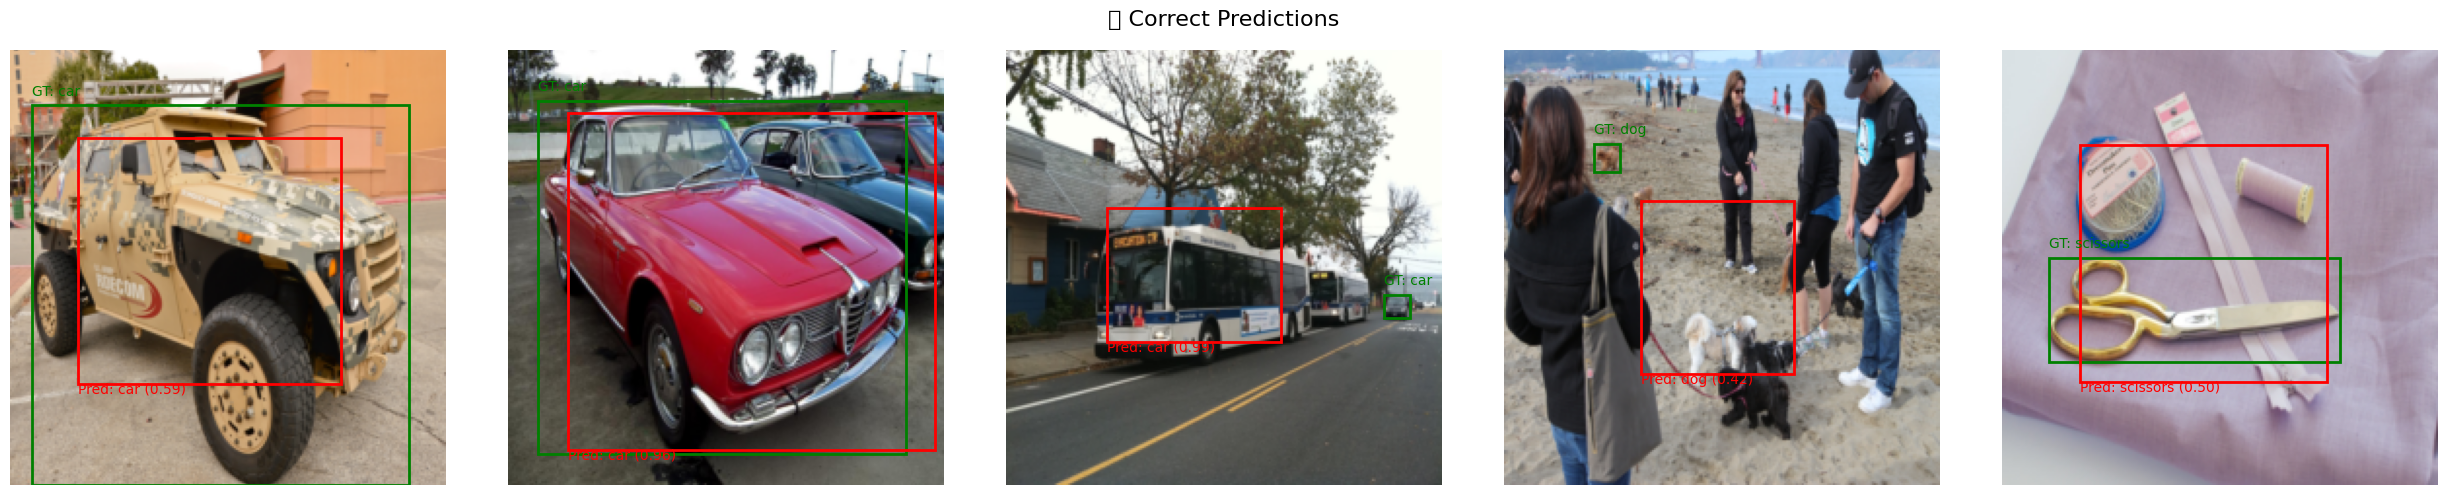

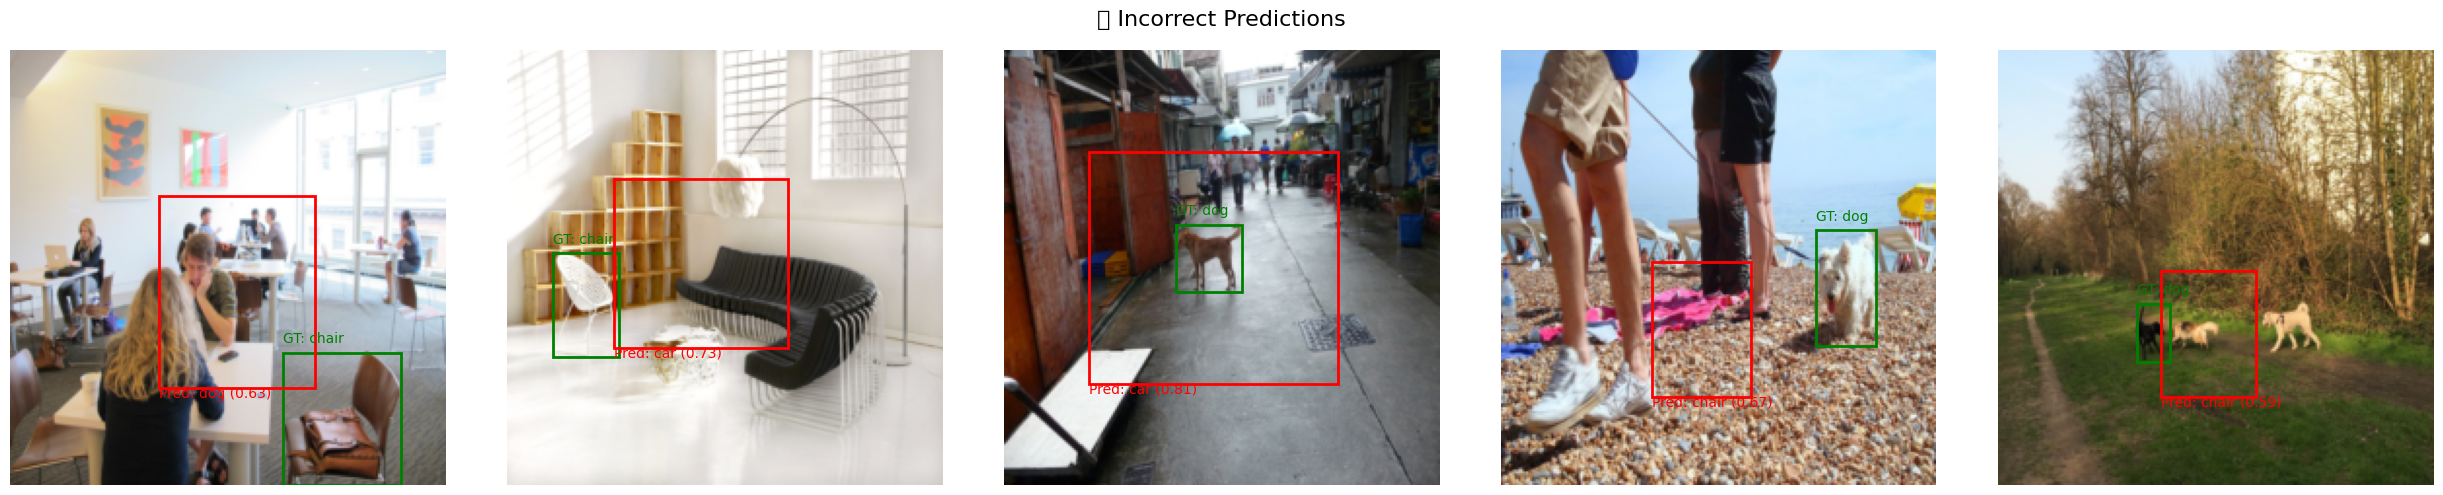

In [190]:
# зворотне відображення індекс → назва класу
idx_to_class = {v: k for k, v in class_to_idx.items()}

visualize_predictions(
    model=best_model,
    dataset=test_dataset,
    class_idx_to_name=idx_to_class,
    device=device,
    num_examples=5
)
